In [1]:
# partially based on http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html

%matplotlib inline

import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib as mpl
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import spreg
import libpysal
from libpysal.weights import Queen
from libpysal.weights import Rook
from sklearn.metrics import mean_squared_error as mse
import esda
import diagnostics

# Data

## Data editing
The csv file includes data for all the variables. Before it is used for the regression analysis, some editing is performed. Furthermore, all the areas outside of the contiguous US, including oceans, are erased.

In [29]:
# load file containing all the variables
directory = os.path.abspath('')
input_file = os.path.join(directory, 'data/data_regression.csv')
data = pd.read_csv(input_file, dtype={'state': str, 'region': str}, delimiter='\t')

# convert to geopandas dataframe
geometry = [Point(xy) for xy in zip(data.X, data.Y)]
data = GeoDataFrame(data, geometry=geometry)
data = data.set_crs(epsg=4326)
data = data.drop_duplicates(subset=['geometry'])  # drop duplicates (due to error in shapefile)
data = data.rename(columns={"total": "metal"}) # rename column

# filter data based on land mask
data = data.loc[data['land_mask'] == 1]

# edit variables to make them more easily readable
# convert to mol/km
data['SO2_19_20'] = data['SO2_19_20']*1000

# convert to m/a
data['prec'] = data['prec']/1000

# convert distances to km
data['water'] = data['water']/1000 # body of water

# logarithmize skewed variables
data["metal_log"] = data["metal"].apply(lambda x: np.log(x) if x != 0 else x)
data["manuf_log"] = data["manuf"].apply(lambda x: np.log(x) if x != 0 else x)
data["veh_log"] = data["veh"].apply(lambda x: np.log(x) if x != 0 else x)
data["power_log"] = data["power"].apply(lambda x: np.log(x) if x != 0 else x)
data["pop_log"] = data["pop"].apply(lambda x: np.log(x) if x != 0 else x)
data["green_log"] = data["green"].apply(lambda x: np.log(x) if x != 0 else x)
data["non_green_log"] = data["non_green"].apply(lambda x: np.log(x) if x != 0 else x)
data["no_website_log"] = data["no_websites"].apply(lambda x: np.log(x) if x != 0 else x)

display(data)

,elev,green,manuf,non_green,no_websites,pop,power,prec,primary,SO2_19_20,...,land_mask,geometry,metal_log,manuf_log,veh_log,power_log,pop_log,green_log,non_green_log,no_website_log
14949,327.22064,0,0,0,0,0.00269,0,0.783622,0,0.128616,...,1,POINT (-95.17201 49.39387),0.0,0.0,0.000000,0.0,-5.918214,0.0,0.0,0.0
15979,335.17276,0,0,0,0,0.00387,0,0.812480,0,0.105423,...,1,POINT (-95.17201 49.33098),0.0,0.0,3.939312,0.0,-5.554501,0.0,0.0,0.0
15980,334.26370,0,0,0,0,0.56157,0,0.807633,0,0.040708,...,1,POINT (-95.10913 49.33098),0.0,0.0,6.424644,0.0,-0.577019,0.0,0.0,0.0
15981,333.17050,0,0,0,0,0.77617,0,0.807518,0,0.053627,...,1,POINT (-95.04625 49.33098),0.0,0.0,7.214346,0.0,-0.253384,0.0,0.0,0.0
15982,329.44119,0,0,0,0,0.42692,0,0.802432,0,0.072201,...,1,POINT (-94.98337 49.33098),0.0,0.0,6.247216,0.0,-0.851159,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423046,0.00000,0,0,0,0,0.00000,0,1.433354,0,0.039660,...,1,POINT (-81.52660 24.49257),0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
424069,0.00000,0,0,0,0,0.00000,0,1.452301,0,0.027575,...,1,POINT (-81.96678 24.42968),0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
424070,0.00000,0,0,0,0,0.00000,0,1.450490,0,0.020942,...,1,POINT (-81.90390 24.42968),0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
424071,0.00000,0,0,0,0,0.00000,0,1.448255,0,0.015185,...,1,POINT (-81.84101 24.42968),0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


## Data exploration
### Variable statistics
Show mean, min/max values etc. for all the variables

In [23]:
# describe most important statistical measures for explanatory variables
all_variables = ['metal_log', 'manuf_log', 'temp', 'prec', 'water',  'elev', 'power_log', 'pop_log', 'veh_log']  # variables with log
data_description = round(data[all_variables].describe(), 2)

display(data_description.T)

,count,mean,std,min,25%,50%,75%,max
metal_log,216058.0,0.08,0.55,0.00,0.00,0.00,0.00,8.52
manuf_log,216058.0,0.65,1.63,0.00,0.00,0.00,0.00,11.19
temp,216058.0,11.41,5.79,-2.31,6.66,10.86,16.10,25.83
prec,216058.0,0.94,0.48,0.07,0.50,0.93,1.29,4.14
water,216058.0,64.69,60.60,0.00,18.23,46.59,94.92,359.98
elev,216058.0,762.78,721.46,-81.08,205.59,457.21,1260.69,3797.81
power_log,216058.0,0.01,0.16,0.00,0.00,0.00,0.00,7.19
pop_log,216058.0,0.40,3.05,-9.21,-1.45,0.43,2.59,9.85
veh_log,216058.0,9.30,2.86,-7.78,7.87,9.59,11.00,17.61


# Regression analysis

## Spatial weights matrix
Create a Queen contiguity spatial weights matrix

In [24]:
# read shapefile for spatial weights matrix
directory = os.path.abspath('')
polygon_data = os.path.join(directory, 'data/shapefile_landmask.shp')
wq = Queen.from_shapefile(polygon_data)
wq.transform = 'v'   # variance stabilizing

C:\Users\bonvi\anaconda3\envs\geodata\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)


## Formulas

In [25]:
# based on https://spreg.readthedocs.io/en/latest/_modules/spreg/diagnostics.html#akaike

def AIC(x):
    
    def sum_residuals(x):
        data['y_hats'] = x.predy
        data['residuals'] = data['y_hats'] - data['SO2_19_20'] 
        res = data['residuals'].to_numpy()
        square = np.square(res)
        sum_squares = np.sum(square)

        return sum_squares
            
    k = x.k       # (scalar) number of explanatory vars (including constant)
    n = x.n       # (scalar) number of observations

    utu = sum_residuals(x)
    aic_result = 2 * k + n * (np.log((2 * np.pi * utu) / n) + 1)
    return aic_result

# write coefficients to list
def get_coefficients(model):
    tick = 0
    coefficients = []
    
    for entry in range(0,len(x5)+1):
        try:
            coeff1 = round(model.betas[tick][0], 5)
            p_value = round(model.t_stat[tick][1], 5)
            coefficients.append([str(coeff1), str(p_value)])
            tick += 1
        except:
            coeff1 = "-"
            coefficients.append(str(coeff1))
            tick += 1
      
    return coefficients

# calculate indirect effects
def indirect_effects(model, variables):

    b = model.betas[:-1] # betas/regressionskoeffizienten
    rho = model.betas[-1] # rho

    btot = b / (1.0-rho) # total effect
    bind = btot -b # indirect effect (durch den lag-efect der benachbarten Gebiete)

    variables.insert(0, "constant")

    indirect_effects = np.concatenate((btot, bind), axis=1)
    df = pd.DataFrame(data=indirect_effects, index=variables, columns=["total", "indirect"])
    df = round(df, 5)
    display(df)

## OLS model

The following OLS model was chosen as the most suitable.
Due to the high VIF, the land cover variable was dropped. Due to its high p-values, 'power_log' was dropped.

In [26]:
# explanatory variables
x1 = ['metal_log', 'manuf_log', 'veh_log', 'temp', 'prec', 'water', 'elev']

# filter data
data_filtered = data.loc[:, x1 + ['SO2_19_20'] + ['X'] + ['Y']].astype(float).dropna()

# dependent variable
y = data_filtered['SO2_19_20']

# create arrays for dependent and explanatory variables
x_values = data_filtered.astype(float).drop(['SO2_19_20', 'X', 'Y'], axis=1).values
y_values = y.astype(float).values[:, None]

# names
names_x = data_filtered.drop(['SO2_19_20'] + ['X'] + ['Y'], axis=1).columns.tolist()

m1 = spreg.OLS(y_values, x_values, w=wq, spat_diag=True, name_x=names_x, name_y='SO2_19_20') # w is only necessary for spatial diagnostics
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   SO2_19_20                Number of Observations:      216058
Mean dependent var  :      0.1687                Number of Variables   :           8
S.D. dependent var  :      0.0764                Degrees of Freedom    :      216050
R-squared           :      0.2392
Adjusted R-squared  :      0.2392
Sum squared residual:     959.164                F-statistic           :   9705.3030
Sigma-square        :       0.004                Prob(F-statistic)     :           0
S.E. of regression  :       0.067                Log likelihood        :  278646.014
Sigma-square ML     :       0.004                Akaike info criterion : -557276.028
S.E of regression ML:      0.0666                Schwarz criterion     : -557193.761

-----------------------------------------------------------------------------

### Calculate spatial autocorrelation of OLS residuals

In [7]:
# calculate difference between prediction and actual counts
data_filtered['y_hats_m1'] = m1.predy
data_filtered['residuals_m1'] = data_filtered['y_hats_m1'] - data_filtered['SO2_19_20'] 

# calculate Moran's I for residuals
mi_m1 = esda.moran.Moran(data_filtered['residuals_m1'], wq)

print("Moran's I: ", round(mi_m1.I, 3), ", p-value: ", mi_m1.p_sim)

Moran's I:  0.861 , p-value:  0.001


## SLX model
A spatial lag variable (in this case, number_employees_primary) is added for each row, containing the values for the neighbouring cells. Therefore, it is basically an extension of the OLS model.

In [9]:
# filtered data
x1 = ['metal_log', 'manuf_log', 'veh_log', 'temp', 'prec', 'water', 'elev']

data_filtered = data.loc[:, x1 + ['SO2_19_20'] + ['X'] + ['Y']].astype(float).dropna()

# dependent variable
y = data_filtered['SO2_19_20']

# create arrays for models
x_values = data_filtered.astype(float).drop(['SO2_19_20', 'X', 'Y'], axis=1).values
y_values = y.astype(float).values[:, None]

# names
names_x = data_filtered.drop(['SO2_19_20'] + ['X'] + ['Y'], axis=1).columns.tolist()
data_w = data_filtered.assign(w=libpysal.weights.lag_spatial(wq, data_filtered['metal_log'].values))

# SLX model
m2 = spreg.OLS(y.values[:, None], data_w.drop(['SO2_19_20', 'X', 'Y'], axis=1).values,
                  w=wq, name_x=names_x, name_y='SO2_19_20')

print(m2.summary)
# not included in summary
print("Coefficient for w: ", round(m2.betas[-1][0], 5), ", p-value: ", round(m2.t_stat[-1][1], 5))

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   SO2_19_20                Number of Observations:      216058
Mean dependent var  :      0.1687                Number of Variables   :           9
S.D. dependent var  :      0.0764                Degrees of Freedom    :      216049
R-squared           :      0.2450
Adjusted R-squared  :      0.2450
Sum squared residual:     951.828                F-statistic           :   8765.6899
Sigma-square        :       0.004                Prob(F-statistic)     :           0
S.E. of regression  :       0.066                Log likelihood        :  279475.414
Sigma-square ML     :       0.004                Akaike info criterion : -558932.829
S.E of regression ML:      0.0664                Schwarz criterion     : -558840.279

-----------------------------------------------------------------------------

## Spatial lag model
A spatial lag of the dependent variable is considered in this model. \
spreg.ML_Error & ML_Lag models did not work due to memory

In [10]:
# filtered data
x1 = ['metal_log', 'manuf_log', 'veh_log', 'temp', 'prec'] 

data_filtered = data.loc[:, x1 + ['SO2_19_20'] + ['X'] + ['Y']].astype(float).dropna()

# dependent variable
y = data_filtered['SO2_19_20']

# create arrays for models
x_values = data_filtered.astype(float).drop(['SO2_19_20', 'X', 'Y'], axis=1).values
y_values = y.astype(float).values[:, None]

# names
names_x = data_filtered.drop(['SO2_19_20'] + ['X'] + ['Y'], axis=1).columns.tolist()
    
m3 = spreg.GM_Lag(y_values, x_values, w=wq, spat_diag=True, name_x=names_x, name_y='SO2_19_20')
print(m3.summary)

indirect_effects(m3, x1)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   SO2_19_20                Number of Observations:      216058
Mean dependent var  :      0.1687                Number of Variables   :           7
S.D. dependent var  :      0.0764                Degrees of Freedom    :      216051
Pseudo R-squared    :      0.8948
Spatial Pseudo R-squared:  0.1301

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.0117871       0.0004595      25.6537995       0.0000000
           metal_log       0.0004119       0.0001110       3.7100311       0.0002072
           manuf_log       0.0007225       0.0000498      1

,total,indirect
constant,0.14106,0.12928
metal_log,0.00493,0.00452
manuf_log,0.00865,0.00792
veh_log,-0.00513,-0.00470
temp,0.00205,0.00188
prec,0.05035,0.04615


## Comparison of model performance
### RMSE

In [10]:
rmses = pd.Series({'OLS': mse(y, m1.predy.flatten(), squared=False),
                  'SLX': mse(y, m2.predy.flatten(), squared=False),
                  'Lag': mse(y, m3.predy.flatten(), squared=False)
                    })

rmses = rmses.sort_values()
display(rmses.to_frame())

,0
Lag,0.023927
SLX,0.066375
OLS,0.066629


### AIC

In [11]:
y_true = y.to_numpy()
aics = pd.Series({'OLS': AIC(m1),
                  'SLX': AIC(m2),
                  'Lag': AIC(m3)
                    })

aics = aics.sort_values(ascending=True)
display(aics.to_frame())

,0
Lag,-999811.844941
SLX,-558924.251471
OLS,-557276.027518


### Model predictions

In [12]:
# use model to predict entire data set (ŷ)
data['y_hats_m1'] = m1.predy
data['y_hats_m2'] = m2.predy
data['y_hats_m3'] = m3.predy

# calculate difference between prediction and actual counts
data['residuals_m1'] = data['y_hats_m1'] - data['SO2_19_20'] 
data['residuals_m2'] = data['y_hats_m2'] - data['SO2_19_20']
data['residuals_m3'] = data['y_hats_m3'] - data['SO2_19_20']

predicted_m1 = data['y_hats_m1']
predicted_m2 = data['y_hats_m2']
predicted_m3 = data['y_hats_m3']
actual = y

### Scatterplots

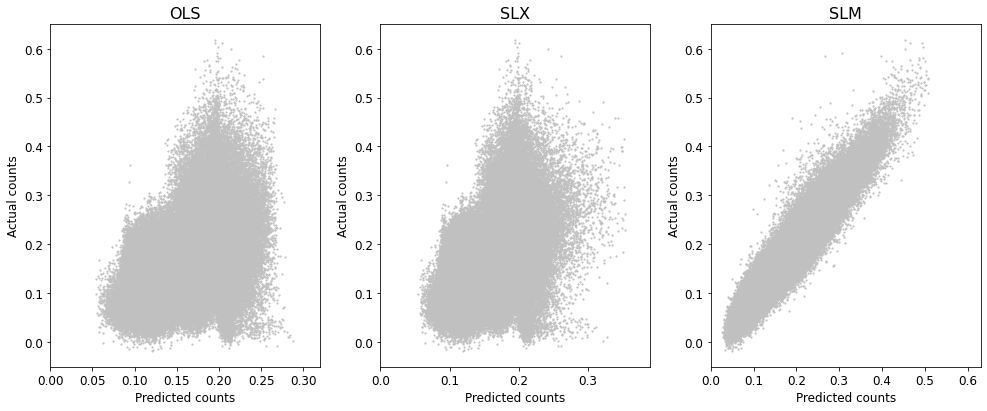

In [22]:
# make scatter plot for all three models
import matplotlib.gridspec as gridspec

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(14,6))
#fig.suptitle('Scatter plot of actual versus predicted counts')
gs = gridspec.GridSpec(1,3)
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# ax3 = fig.add_subplot

ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
plt.scatter(x=predicted_m1, y=actual, marker='.', s=5, color='#C0C0C0')
plt.xlim([0, 0.32])
ax1.set_title('OLS')
ax1.set_xlabel('Predicted counts')
ax1.set_ylabel('Actual counts')

ax2 = plt.subplot(gs[0, 1])
plt.scatter(x=predicted_m2, y=actual, marker='.', s=5, color='#C0C0C0')
plt.xlim([0, 0.39])
ax2.set_title('SLX')
ax2.set_xlabel('Predicted counts')
ax2.set_ylabel('Actual counts')

ax3 = plt.subplot(gs[0, 2])
plt.scatter(x=predicted_m3, y=actual, marker='.', s=5, color='#C0C0C0')
plt.xlim([0, 0.63])
ax3.set_title('SLM')
ax3.set_xlabel('Predicted counts')
ax3.set_ylabel('Actual counts')


plt.tight_layout()
plt.show()


### Spatial distribution of residuals

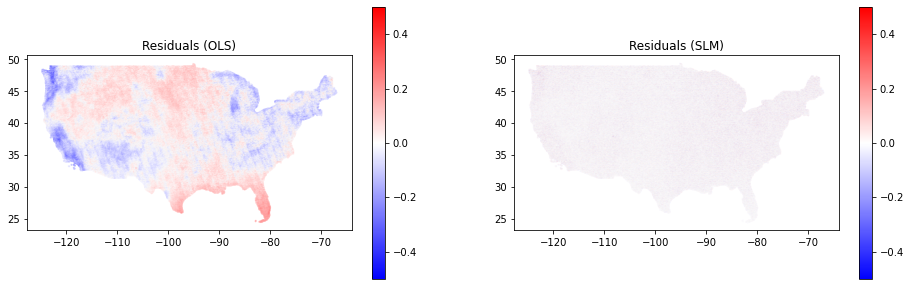

In [30]:
# plot map of residuals 
fig, ax = plt.subplots(figsize=(16,5), nrows=1, ncols=2)
sub1 = data.plot(column='residuals_m1', cmap='bwr', edgecolor=None, legend=True, ax=ax[0], markersize=0.01, vmin=-0.5, vmax=0.5)
sub1.title.set_text('Residuals (OLS)')
sub3 = data.plot(column='residuals_m3', cmap='bwr', edgecolor=None, legend=True, ax=ax[1], markersize=0.01, vmin=-0.5, vmax=0.5)
sub3.title.set_text('Residuals (SLM)')


### Spatial autocorrelation of residuals

In [31]:
mi_SO2 = esda.moran.Moran(data['SO2_19_20'], wq)
mi_m1 = esda.moran.Moran(data['residuals_m1'], wq)
mi_m2 = esda.moran.Moran(data['residuals_m2'], wq)
mi_m3 = esda.moran.Moran(data['residuals_m3'], wq)

print("Moran's I (dependent variable): ", round(mi_SO2.I, 3), ", p-value: ", mi_SO2.p_sim)
print("Moran's I (OLS): ", round(mi_m1.I, 3), ", p-value: ", mi_m1.p_sim)
print("Moran's I (SLX): ", round(mi_m2.I, 3), ", p-value: ", mi_m2.p_sim)
print("Moran's I (SLM): ", round(mi_m3.I, 3), ", p-value: ", mi_m3.p_sim)

Moran's I (dependent variable):  0.901 , p-value:  0.001
Moran's I (OLS):  0.861 , p-value:  0.001
Moran's I (SLX):  0.862 , p-value:  0.001
Moran's I (SLM):  -0.123 , p-value:  0.001


## Final model
Three variables based on web text mining are considered to answer the research questions.

### Variable statistics

In [32]:
data_description = round(data[['green_log', 'non_green_log', 'no_website_log']].describe(), 2)
display(data_description.T)

,count,mean,std,min,25%,50%,75%,max
green_log,216058.0,0.01,0.21,0.0,0.0,0.0,0.0,8.01
non_green_log,216058.0,0.04,0.42,0.0,0.0,0.0,0.0,8.52
no_website_log,216058.0,0.04,0.37,0.0,0.0,0.0,0.0,8.01


In [27]:
# filtered data
x1_web = ['green_log', 'non_green_log', 'no_website_log', 'manuf_log', 'veh_log', 'temp', 'prec'] 

data_filtered = data.loc[:,x1_web + ['SO2_19_20'] + ['X'] + ['Y']].astype(float).dropna()

# dependent variable
y = data_filtered['SO2_19_20']

# create arrays for models
x_values = data_filtered.astype(float).drop(['SO2_19_20', 'X', 'Y'], axis=1).values
y_values = y.astype(float).values[:, None]

# names
names_x = data_filtered.drop(['SO2_19_20'] + ['X'] + ['Y'], axis=1).columns.tolist()
    
m_web = spreg.GM_Lag(y_values, x_values, w=wq, spat_diag=True, name_x=names_x, name_y='SO2_19_20')
print(m_web.summary)

# calculate indirect effects
indirect_effects(m_web, x1_web)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   SO2_19_20                Number of Observations:      216058
Mean dependent var  :      0.1687                Number of Variables   :           9
S.D. dependent var  :      0.0764                Degrees of Freedom    :      216049
Pseudo R-squared    :      0.8948
Spatial Pseudo R-squared:  0.1311

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.0118654       0.0004604      25.7714722       0.0000000
           green_log       0.0001623       0.0002731       0.5943695       0.5522650
       non_green_log       0.0003564       0.0001483       

,total,indirect
constant,0.14057,0.12871
green_log,0.00192,0.00176
non_green_log,0.00422,0.00387
no_website_log,0.00562,0.00514
manuf_log,0.00850,0.00778
veh_log,-0.00506,-0.00464
temp,0.00204,0.00187
prec,0.05034,0.04609


In [34]:
from spreg import diagnostics
print("Standard errors: ", spreg.se_betas(m_web))
print("Coefficients: ", m_web.betas)
print("Z-statistic, p-value: ", diagnostics.t_stat(m_web))

Standard errors:  [4.57064458e-04 2.58408746e-04 1.40377236e-04 1.53552946e-04
 4.75707656e-05 2.19071945e-05 1.12828692e-05 2.20014867e-07
 4.17332287e-03]
Coefficients:  [[-7.50726559e-04]
 [-5.33468468e-06]
 [-7.99860395e-05]
 [ 2.15108986e-04]
 [-9.24730018e-05]
 [-2.19302935e-05]
 [-6.12924381e-06]
 [-5.10044008e-07]
 [ 1.00923557e+00]]
Z-statistic, p-value:  [(-1.64249603297798, 0.1004887029272371), (-0.020644365791615275, 0.9835293682772799), (-0.56979352273235, 0.5688183417050172), (1.4008782731789837, 0.1612519131672061), (-1.9439040081744745, 0.051908324323936085), (-1.0010544022603376, 0.31680162907925313), (-0.5432345020900133, 0.5869689145845436), (-2.3182251964828766, 0.020438014150189077), (241.83021603396773, 0.0)]


### Normalized predictors

In [35]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler() # scale: 0 - 1

x1_web = ['green_log', 'non_green_log', 'no_website_log', 'manuf_log', 'veh_log', 'temp', 'prec'] 
data_filtered = data.loc[:, x1_web + ['SO2_19_20'] + ['X'] + ['Y']].astype(float).dropna()

# dependent variable
y = data_filtered['SO2_19_20']

# create arrays for models
y_values = y.astype(float).values[:, None]

# use StandardScaler to standardize all variables
standardized = ss.fit_transform(data_filtered[x1_web].values)

# convert numpy array to pandas dataframe
# standardized_df = pd.DataFrame(standardized, columns=data_filtered[x1].columns)

names_x = data_filtered.drop(['SO2_19_20'] + ['X'] + ['Y'], axis=1).columns.tolist()

model_standardized = spreg.GM_Lag(y_values, standardized, w=wq, spat_diag=True, name_x=names_x, name_y='SO2_19_20')

print(model_standardized.summary)

# calculate indirect effects
indirect_effects(model_standardized, x1_web)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   SO2_19_20                Number of Observations:      216058
Mean dependent var  :      0.1687                Number of Variables   :           9
S.D. dependent var  :      0.0764                Degrees of Freedom    :      216049
Pseudo R-squared    :      0.9019
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0006014       0.0005188      -1.1593466       0.2463149
           green_log      -0.0000427       0.0020689      -0.0206444       0.9835293
       non_green_lo

,total,indirect
constant,0.06512,0.06572
green_log,0.00462,0.00467
non_green_log,0.07376,0.07445
no_website_log,-0.18648,-0.18820
manuf_log,0.11205,0.11308
veh_log,0.06028,0.06084
temp,0.01868,0.01885
prec,0.22479,0.22686


### Variance Inflation Factor

In [36]:
# values are identical for different models
vifs = pd.DataFrame()
vif_factor = []
x_columns = []

tick = 0

# get VIF for every variable
for x_variable in names_x:
    
    tick += 1
    
    vif = round(spreg.vif(m_web)[tick][0], 2) # access VIF output
    vif_factor.append(vif)
    x_columns.append(x_variable)
    
# create dataframe from loop
vifs = pd.DataFrame(list(zip(x_columns, vif_factor)), 
           columns =['variable', 'VIF']) 

display(vifs)

,variable,VIF
0,green_log,1.08
1,non_green_log,1.28
2,no_website_log,1.24
3,manuf_log,1.57
4,veh_log,1.45
5,temp,1.11
6,prec,1.14
